<a href="https://colab.research.google.com/github/JingQian87/AppliedDL/blob/master/a2_jq2282.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1. Train a model on an existing dataset

### 1. Classify images using transfer learning from mini-flowers dataset
Download the ​mini-flowers​ dataset. This contains 1,500 images of five different types of flowers. Modify one of the above notebooks to classify these images using transfer learning. How accurate of a model can you train? ​Note: the example notebooks are for binary classification. You will need to change the output layer shape, activation, and loss function for multiclass classification.

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Step1. Load and explore data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
local_zip = '/content/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
!ls '/tmp/'
!ls '/tmp/train/'

drivefs_ipc.0  drivefs_ipc.0_shell  LICENSE.txt  train	val
daisy  dandelion  roses  sunflowers  tulips


In [0]:
base_dir = '/tmp'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'val')

In [0]:
total_train = 0
for i in os.listdir(train_dir):
  tmp = len(os.listdir(os.path.join(train_dir, i)))
  print('Training ', i, ' images:', tmp)
  total_train += tmp
 
total_val = 0
for i in os.listdir(validation_dir):
  tmp = len(os.listdir(os.path.join(validation_dir, i)))
  print('Validation ', i, ' images:', tmp)
  total_val += tmp
  
print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training  roses  images: 200
Training  tulips  images: 200
Training  dandelion  images: 200
Training  daisy  images: 200
Training  sunflowers  images: 200
Validation  roses  images: 100
Validation  tulips  images: 100
Validation  dandelion  images: 100
Validation  daisy  images: 100
Validation  sunflowers  images: 100
--
Total training images: 1000
Total validation images: 500


### Step2. Use VGG model

In [0]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
#conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 5s 0us/step


In [0]:
# Images be resized to TARGET_SHAPE * TARGET_SHAPE pixels as they're read off the disk
TARGET_SHAPE = 150
BATCH_SIZE = 32

In [13]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [14]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 0s 490us/sample - loss: 1.4360 - acc: 0.5070 - val_loss: 0.8519 - val_acc: 0.6860
Epoch 2/50
1000/1000 [==============================] - 0s 292us/sample - loss: 0.7758 - acc: 0.7180 - val_loss: 0.7484 - val_acc: 0.7040
Epoch 3/50
1000/1000 [==============================] - 0s 297us/sample - loss: 0.5793 - acc: 0.7860 - val_loss: 0.6236 - val_acc: 0.7840
Epoch 4/50
1000/1000 [==============================] - 0s 295us/sample - loss: 0.4667 - acc: 0.8370 - val_loss: 0.7211 - val_acc: 0.7080
Epoch 5/50
1000/1000 [==============================] - 0s 299us/sample - loss: 0.3754 - acc: 0.8700 - val_loss: 0.6672 - val_acc: 0.7580
Epoch 6/50
1000/1000 [==============================] - 0s 299us/sample - loss: 0.2671 - acc: 0.9070 - val_loss: 0.5662 - val_acc: 0.8020
Epoch 7/50
1000/1000 [==============================] - 0s 307us/sample - loss: 0.2208 - acc: 0.9370 - val_loss: 0.6658 - val

The translation model without fine tuning using VGG get overfitted quickly. 
So we could add fine tuning.

In [15]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 18,912,069
Trainable params: 18,912,069
Non-trainable params: 0
_________________________________________________________________


In [16]:
conv_base.trainable = False
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 50
history2 = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
16/16 [==============================] - 3s 184ms/step - loss: 0.9102 - acc: 0.6520
 - 11s - loss: 1.9253 - acc: 0.4040 - val_loss: 0.9102 - val_acc: 0.6520
Epoch 2/50
16/16 [==============================] - 3s 169ms/step - loss: 0.8086 - acc: 0.7040
 - 10s - loss: 0.9429 - acc: 0.6460 - val_loss: 0.8086 - val_acc: 0.7040
Epoch 3/50
16/16 [==============================] - 3s 168ms/step - loss: 0.7328 - acc: 0.7400
 - 10s - loss: 0.8848 - acc: 0.6570 - val_loss: 0.7328 - val_acc: 0.7400
Epoch 4/50
16/16 [==============================] - 3s 170ms/step - loss: 0.6815 - acc: 0.7360
 - 10s - loss: 0.8050 - acc: 0.7080 - val_loss: 0.6815 - val_acc: 0.7360
Epoch 5/50
16/16 [==============================] - 3s 172ms/step - loss: 0.6337 - acc: 0.7700
 - 10s - loss: 0.7128 - acc: 0.7370 - val_loss: 0.6337 - val_acc: 0.7700
Epoch 6/50
16/16 [==============================] - 3s 169ms/step - loss: 0.5885 - acc: 0.8040
 - 10s - loss: 0.7022 - acc: 0.7300 - val_loss: 0.5885 - val_acc:

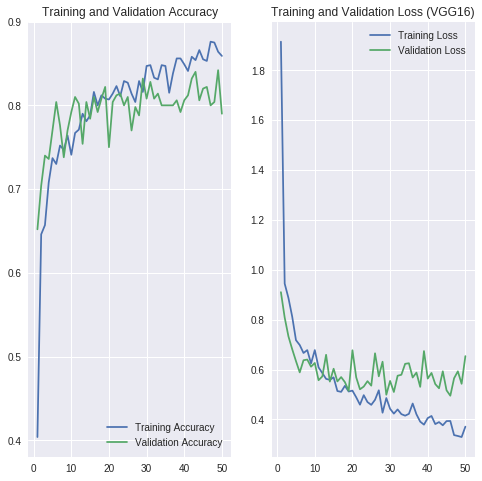

In [19]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (VGG16)')
plt.show()

### 2. Run experiments using at least two pretrained convolutional bases
Run experiments using at least two pretrained convolutional bases and compare your results. Include a short, informal write-up (using bullet points is fine). What differences do you see, and why? Read the associated papers to learn more about the networks you’re using, linked from the API doc.

Model 1: ResNet50

https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py

https://github.com/keras-team/keras-applications

In [0]:
from keras.applications.resnet50 import ResNet50
conv_base2 = ResNet50(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
conv_base2.summary()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048))#from ResNet
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base2.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
FLATTENED_SHAPE = 5 * 5 * 2048

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history3 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 2.9497 - acc: 0.2270 - val_loss: 1.5704 - val_acc: 0.3260
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.5940 - acc: 0.2480 - val_loss: 1.5755 - val_acc: 0.2140
Epoch 3/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.5853 - acc: 0.2300 - val_loss: 1.5774 - val_acc: 0.3540
Epoch 4/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.5776 - acc: 0.2370 - val_loss: 1.5496 - val_acc: 0.2940
Epoch 5/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.5824 - acc: 0.2120 - val_loss: 1.5599 - val_acc: 0.2440
Epoch 6/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.5775 - acc: 0.2340 - val_loss: 1.5553 - val_acc: 0.3400
Epoch 7/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.5779 - acc: 0.2540 - val_loss: 1.5566 - val_acc: 0.3040
E

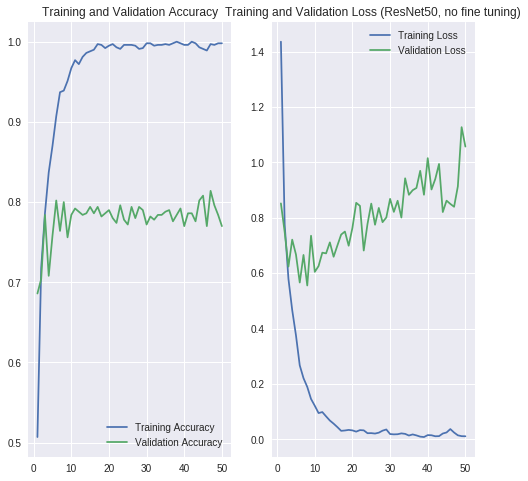

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (ResNet50, no fine tuning)')
plt.show()

Model 2, Inception V3


In [0]:
from keras.applications.inception_v3 import InceptionV3
conv_base3 = InceptionV3(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
conv_base3.summary()

87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base3.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
FLATTENED_SHAPE = 3 * 3 * 2048

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history5 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 8.6892 - acc: 0.3990 - val_loss: 5.9858 - val_acc: 0.5960
Epoch 2/50
1000/1000 [==============================] - 0s 437us/sample - loss: 7.0262 - acc: 0.5340 - val_loss: 6.3275 - val_acc: 0.5820
Epoch 3/50
1000/1000 [==============================] - 0s 431us/sample - loss: 6.2728 - acc: 0.5790 - val_loss: 6.0903 - val_acc: 0.6020
Epoch 4/50
1000/1000 [==============================] - 0s 445us/sample - loss: 6.0622 - acc: 0.5940 - val_loss: 5.0466 - val_acc: 0.6560
Epoch 5/50
1000/1000 [==============================] - 0s 429us/sample - loss: 5.7165 - acc: 0.6180 - val_loss: 5.4613 - val_acc: 0.6140
Epoch 6/50
1000/1000 [==============================] - 0s 433us/sample - loss: 4.7544 - acc: 0.6540 - val_loss: 4.2960 - val_acc: 0.6940
Epoch 7/50
1000/1000 [==============================] - 0s 437us/sample - loss: 4.1314 - acc: 0.7020 - val_loss: 3.9082 - val_a

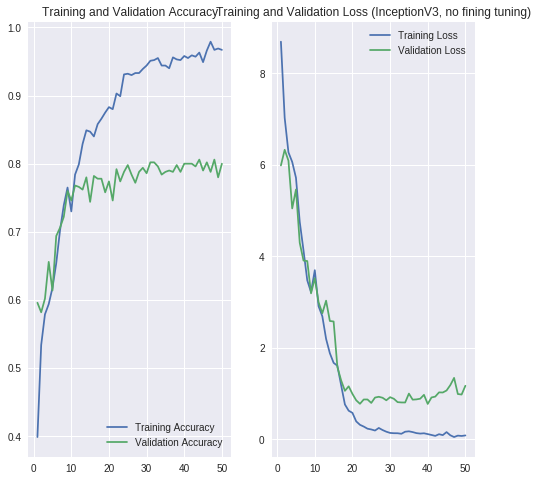

In [0]:
acc = history5.history['acc']
val_acc = history5.history['val_acc']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (InceptionV3, no fining tuning)')
plt.show()

InceptionV3超级快。也不能算overfitting吧，只是training上升得快但validation没有下降呀。
准确度差不多，倒是loss 差别挺大的